In [ ]:
#
# Statistical Analysis for the WL sampling L4_SS
# João Inácio, June 16th 2021
#

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [4]:
# System and simulation information

dim = "2D"
lattice = "SS"
NN = 4

L = 4
N_atm = 1 * L ** 2

max_E = (1 / 2) * NN * N_atm
max_M = N_atm
NE = int(1 + (max_E / 2))
NM = N_atm + 1
energies = np.linspace(- max_E, max_E, NE)
magnetizations = np.linspace(- max_M, max_M, NM)

q_max = (NM + 1) // 2 - 2
if NM % 2 == 0:
    q_max = NM // 2 - 3

flatness = 90

# Regular WL
f_final_exp_vals = np.array([4, 5, 6, 7, 8, 9, 10, 11])
f_final_vals = 1 + 10.0**(-f_final_exp_vals)

n_run = 100


In [5]:
# Declaration of arrays

JDOS_all = list()
for i in range(len(f_final_vals)):
    JDOS_all.append(list())

wall_time_all = np.zeros((n_run, len(f_final_vals)))

cfg_chkbrd = np.zeros((n_run, len(f_final_vals)))
cfg_slice = np.zeros((n_run, len(f_final_vals)))
cfg_zerozero = np.zeros((n_run, len(f_final_vals)))

JDOS_mean = list()
wall_time_mean = list()

In [11]:
# Read computations for regular WL

for k, f_final_exp in enumerate(f_final_exp_vals):
    for run in range(1, n_run + 1):
        file_name = "".join(("./data/wl/L", str(L), "/", str(f_final_exp),"/",
                             str(run), "_JDOS_WL_Ising_", dim, "_", lattice, 
                             "_L", str(L), "_f", str(f_final_exp), 
                             "_flatness", str(flatness)))
        JDOS = np.loadtxt(file_name + ".txt")
        
        cfg_chkbrd[run - 1, k] = JDOS[len(energies) - 1, q_max+1]
        cfg_slice[run - 1, k] = JDOS[L, q_max+1]
        cfg_zerozero[run - 1, k] = JDOS[energies==0, magnetizations==0]

        JDOS_all[k].append(JDOS)

        with open(file_name + "_data.txt", 'r') as data_file:
            header = data_file.readline().strip("\n")
            
            for last_line in data_file:
                pass

            wall_time_all[run - 1, k] = float(last_line)
    
    JDOS_mean.append(sum(JDOS_all[k]) / n_run)
    wall_time_mean.append(sum(wall_time_all[:, k]) / n_run)
    
    #print("f_final: ", f_final_vals[k])
    #print("Mean Wall time: {:.5f} seconds".format(wall_time_mean[k]))
    #print("------------------------------------")


In [10]:
# Fit normal distributions to configurations - regular WL

fit_chkbrd = np.zeros((len(f_final_vals), 2))
fit_slice = np.zeros((len(f_final_vals), 2))
fit_zerozero = np.zeros((len(f_final_vals), 2))

for k in range(len(f_final_vals)):
    #print(f_final_vals[k])
    
    # Checkerboard
    
    fit_chkbrd[k] = norm.fit(cfg_chkbrd[:, k])
    #print("mean: {:.5f}; var: {:.5f}".format(fit_chkbrd[k, 0], fit_chkbrd[k, 1]))

    # Slice
    
    fit_slice[k] = norm.fit(cfg_slice[:, k])
    #print("mean: {:.5f}; var: {:.5f}".format(fit_slice[k, 0], fit_slice[k, 1]))
    
    # Zerozero
    
    fit_zerozero[k] = norm.fit(cfg_zerozero[:, k])
    #print("mean: {:.5f}; var: {:.5f}".format(fit_zerozero[k, 0], fit_zerozero[k, 1]))
    
    #print("------------------------------------")


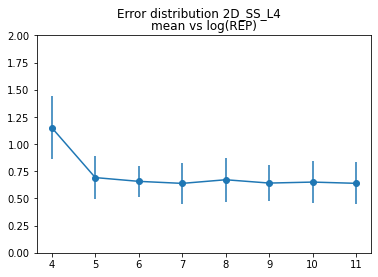

In [23]:
# If L = 4, compute error

if L == 4:
    JDOS_exact = np.loadtxt('JDOS_exact_L4_SS.txt')
    
    mean_error_abs = list()
    mean_error = list()
    var_error = list()
    
    for k in range(len(f_final_exp_vals)):
        error_all = list()
        error_all_abs = list()
        
        for run in range(n_run):
            JDOS_error = JDOS_all[k][run] - JDOS_exact
            JDOS_error = JDOS_error[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]] / JDOS_exact[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]]
            error_all.append(np.sum(np.sum(JDOS_error)))

            JDOS_error_abs = np.abs(JDOS_all[k][run] - JDOS_exact)
            JDOS_error_abs = JDOS_error_abs[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]] / JDOS_exact[np.where(JDOS_exact > 0)[0], np.where(JDOS_exact > 0)[1]]
            error_all_abs.append(np.sum(np.sum(JDOS_error_abs)))
        
        mean_error_abs.append(np.mean(error_all_abs))
        
        fit_error = norm.fit(error_all)
        mean_error.append(fit_error[0])
        var_error.append(fit_error[1])
        
        #print(f_final_exp_vals[k])
        #print("Mean absolute error: {:.5f} ".format(mean_error_abs[k]))
        #print("Mean error: {:.5f} ".format(mean_error[k]))
        #print("Var error: {:.5f} ".format(var_error[k]))
        #print("------------------------------------")
    
    fig, ax1 = plt.subplots(1, 1)
    fig.suptitle("Error distribution " + dim + "_" + 
              lattice + "_L" + str(L))

    ax1.errorbar(f_final_exp_vals, mean_error_abs, var_error, marker='o')
    ax1.set_title("mean vs log(REP)")
    ax1.set_ylim([0, 2])
    
    plt.show()
    

In [24]:
with open("mean_error_abs_L4_SS.txt", 'w') as file:
    for i in range(len(f_final_vals)):
        file.write(f"{f_final_vals[i]} {mean_error_abs[i]} {var_error[i]} \n")
